<a href="https://colab.research.google.com/github/pranavrao87/Machine-Learning/blob/main/Transfer%20Learning/04_transfer_learning_tensorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning w/ TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and patterns for another specific problem

Two main benefits:
- Can leverage an exixsting neural network architecture proven to work on similar problems
- Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then can adapt those patterns to other data

In [1]:
# Check if using gpu
!nvidia-smi

Mon Aug 21 03:15:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading data

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-08-21 03:15:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   195MB/s    in 0.8s    

2023-08-21 03:15:52 (195 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# Walk through the data
import os

for dirpath, dirnames, filenames, in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

Instead of 750 images for each class, there are only 75 training images (compared to previous datasets in Convolutional Neural Network)

## Creating data loaders (Data Preprocessing)

Using the 'ImageDataGenerator' class to load in images in batches

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while model is training)

Callbacks are extra functionality that can be added to models to be performed during or after training. Some common ones:
- Tracking experiments w/ TensorBoard callback
- Model checkpoint w/ ModelCheckpoint callback
- Stopping a model from training (before it trains too long and overfits) w/ EarlyStopping callback

In [5]:
# Create TensorBoard callback (functionized b/c we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

Previously: Used tensorflow to create own models layer by layer from scratch.

Now: Similar process, but majority of the model's layers are coming from TensorFlow Hub.

Can access pretrained models on: https://tfhub.dev/

Specifically for classification models:
  - resnet
  - effecientnet

Additional Resources:
(paperswithcode.com)

Browsed the TensorFlowHub and found following feature vector mdodel link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
# Comparing two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [7]:
# Import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [8]:
# create_mode() to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model w/ it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10

  Returns:
    An uncompiled Keras Sequential model w/ model_url as feature extractor
    layer and Dense output layer w/ num_classes output neurons.
  """

  # Download pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False,
                                            name="feature_extraction_layer",
                                            input_shape=IMAGE_SHAPE+(3,)) # freeeze already learned patterns
  # Creating own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layet")
  ])

  return model

### Creating + testing ResNet TensorFlow Hub Feature Extraction Model

In [9]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)


In [10]:
# Compile model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
# Fitting model (10 percent of the og data)

resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230821-031609
Epoch 1/5
24/24 [==============================] - 28s 636ms/step - loss: 2.1175 - accuracy: 0.3160 - val_loss: 1.3211 - val_accuracy: 0.5848
Epoch 2/5
24/24 [==============================] - 15s 624ms/step - loss: 0.9816 - accuracy: 0.7147 - val_loss: 0.9418 - val_accuracy: 0.6888
Epoch 3/5
24/24 [==============================] - 13s 543ms/step - loss: 0.6683 - accuracy: 0.8213 - val_loss: 0.7948 - val_accuracy: 0.7476
Epoch 4/5
24/24 [==============================] - 11s 452ms/step - loss: 0.5080 - accuracy: 0.8760 - val_loss: 0.7310 - val_accuracy: 0.7632
Epoch 5/5
24/24 [==============================] - 10s 432ms/step - loss: 0.4017 - accuracy: 0.9187 - val_loss: 0.6981 - val_accuracy: 0.7760


Transfer learning feature extractor outperformed all previous models built by "hand" in less training time AND w/ 10% of the training examples. ~

In [12]:
# Creating function to plot loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns seperate loss curve for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

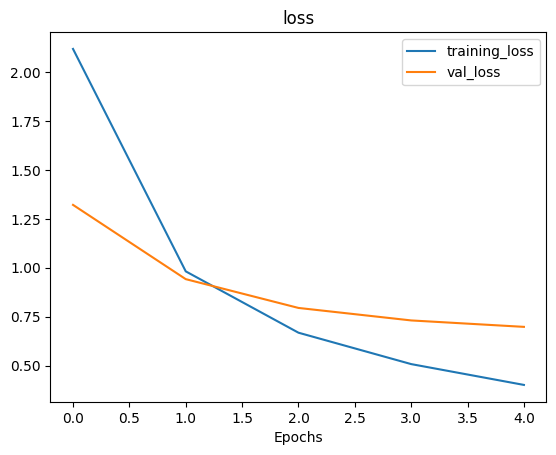

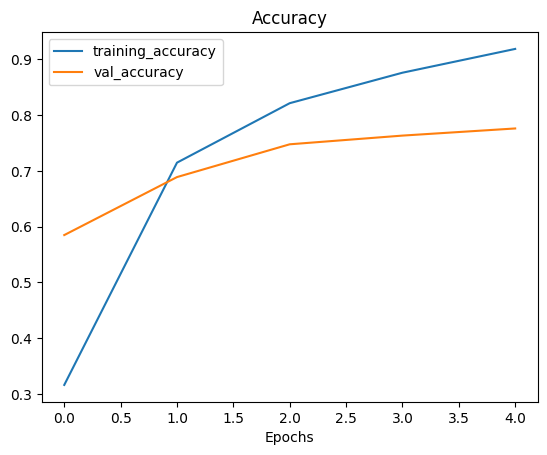

In [13]:
plot_loss_curves(resnet_history)

### Creating + testing EffecientNetB0 TensorFlow Hub Feature Extraction Model

In [14]:
# Create EfficientNetB0 Feature Extractor Model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])


Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230821-031735
Epoch 1/5
24/24 [==============================] - 25s 531ms/step - loss: 1.8503 - accuracy: 0.4360 - val_loss: 1.2681 - val_accuracy: 0.7504
Epoch 2/5
24/24 [==============================] - 10s 431ms/step - loss: 1.0525 - accuracy: 0.7653 - val_loss: 0.8495 - val_accuracy: 0.8284
Epoch 3/5
24/24 [==============================] - 10s 426ms/step - loss: 0.7510 - accuracy: 0.8347 - val_loss: 0.6853 - val_accuracy: 0.8512
Epoch 4/5
24/24 [==============================] - 10s 427ms/step - loss: 0.6046 - accuracy: 0.8640 - val_loss: 0.6016 - val_accuracy: 0.8584
Epoch 5/5
24/24 [==============================] - 9s 403ms/step - loss: 0.5119 - accuracy: 0.8840 - val_loss: 0.5510 - val_accuracy: 0.8640


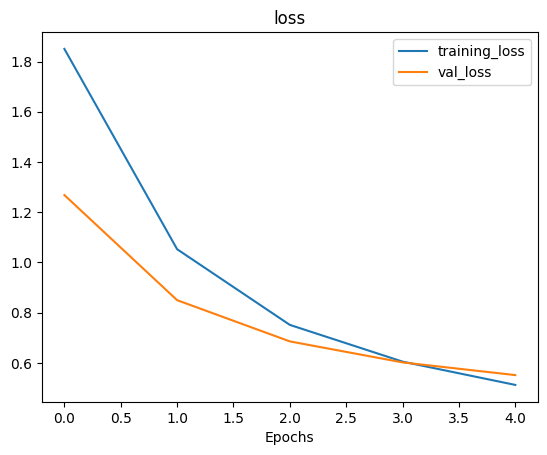

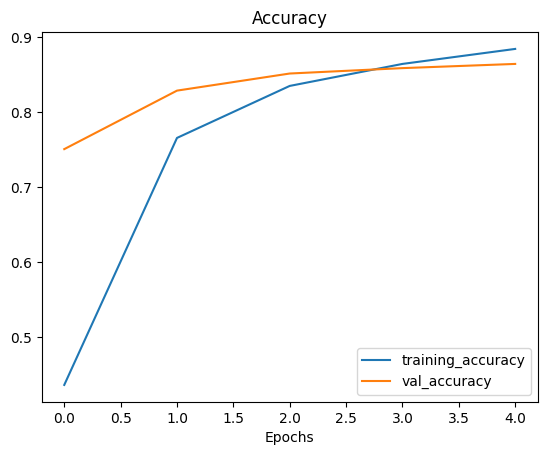

In [15]:
plot_loss_curves(efficientnet_history)

In [16]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layet (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [17]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layet (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


Only the features in the output layer are trainable as everything else is non-trainable and already "frozen"

## Different types of transfer learning

- **"As is"** transfer learning - using an existing model w/ no changes what so ever (ex. using ImageNet model on a 1000 ImageNet classes, none of your own)
- **"Feature extraction"** transfer learning - using the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (ex, 1000 classes --> 10 classes of food)
- **"Fine-tuning"** transfer learning - use prelearned patterns of an existing model and fine tune many or all of the underlying layers (including new output layers)

In [18]:
# How many layers does efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Comparing models results w/ TensorBoard

In [19]:
# Upload TensorBoard dev records (coming from the tensorflow_hub directory)
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two diff TF Hub feature extraction model architectures using 10% of total training data" \
  --one_shot

2023-08-21 03:18:43.543272: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   ZZC-BFK-NZB



New experiment created. View your TensorBoard at: https://tensorboard.dev/ex

TensorBoard experiments uploaded publicly: https://tensorboard.dev/experiment/ebDN2h7ESZ2Fw23orCXr8Q/

In [20]:
# Check what TensorBoard experiments are uploaded
!tensorboard dev list

2023-08-21 03:31:36.639061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/ebDN2h7ESZ2Fw23orCXr8Q/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two diff TF Hub feature extraction model architectures using 10% of total training data
	Id                   ebDN2h7ESZ2Fw23orCXr8Q
	Created              2023-08-21 03:31:30 (8 seconds ago)
	Updated              2023-08-21 03:31:33 (5 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5811169
https://tensorboard.dev/experiment/pmh3XOosRGe6o9gwB8k7iw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two diff TF Hub feature extraction model architectures using 10% of total training data
	Id                   pmh3XOosRGe6o9gwB8k7iw
	Created              2023-08-20 03:45:28 (23 hours ago)
	Updated              20

In [28]:
# Deleting an experiment
!tensorboard dev delete --experiment_id pmh3XOosRGe6o9gwB8k7iw
# Confirm deletion by re-checking what experiments are left

2023-08-21 03:36:32.868595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment pmh3XOosRGe6o9gwB8k7iw.


In [29]:
!tensorboard dev list

2023-08-21 03:36:46.777301: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/ebDN2h7ESZ2Fw23orCXr8Q/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two diff TF Hub feature extraction model architectures using 10% of total training data
	Id                   ebDN2h7ESZ2Fw23orCXr8Q
	Created              2023-08-21 03:31:30 (5 minutes ago)
	Updated              2023-08-21 03:31:33 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5811169
Total: 1 experiment(s)


## Third Model (MobileNet100V2)

In [30]:
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"


# Create mobilenet model
mobilenet_model = create_model(mobilenet_url,
                              num_classes=train_data_10_percent.num_classes)

mobilenet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

mobilenet_model.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                          experiment_name="mobilenetv2")])

Saving TensorBoard log files to: tensorflow_hub/mobilenetv2/20230821-034227
Epoch 1/5
24/24 [==============================] - 16s 448ms/step - loss: 1.8807 - accuracy: 0.3640 - val_loss: 1.2580 - val_accuracy: 0.6276
Epoch 2/5
24/24 [==============================] - 10s 415ms/step - loss: 0.9989 - accuracy: 0.7133 - val_loss: 0.8938 - val_accuracy: 0.7204
Epoch 3/5
24/24 [==============================] - 9s 387ms/step - loss: 0.7231 - accuracy: 0.8067 - val_loss: 0.7391 - val_accuracy: 0.7716
Epoch 4/5
24/24 [==============================] - 9s 385ms/step - loss: 0.5765 - accuracy: 0.8520 - val_loss: 0.6719 - val_accuracy: 0.7904
Epoch 5/5
24/24 [==============================] - 9s 404ms/step - loss: 0.4787 - accuracy: 0.8893 - val_loss: 0.6388 - val_accuracy: 0.7940


In [31]:
# Upload the new TensorBoard dev records (coming from the tensorflow_hub directory)
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2 vs MobileNet100V2" \
  --description "Comparing three diff TF Hub feature extraction model architectures using 10% of total training data" \
  --one_shot

2023-08-21 03:46:03.935642: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/x4a3AfNPRVGE979eSohmhQ/

[2023-08-21T03:46:06] Started scanning logdir.
[2023-08-21T03:46:09] Total uploaded: 90 scalars, 0 tensors, 3 binary objects (7.1 MB)
[2023-08-21T03:46:09] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/x4a3AfNPRVGE979eSohmhQ/


New experiment at: https://tensorboard.dev/experiment/x4a3AfNPRVGE979eSohmhQ/

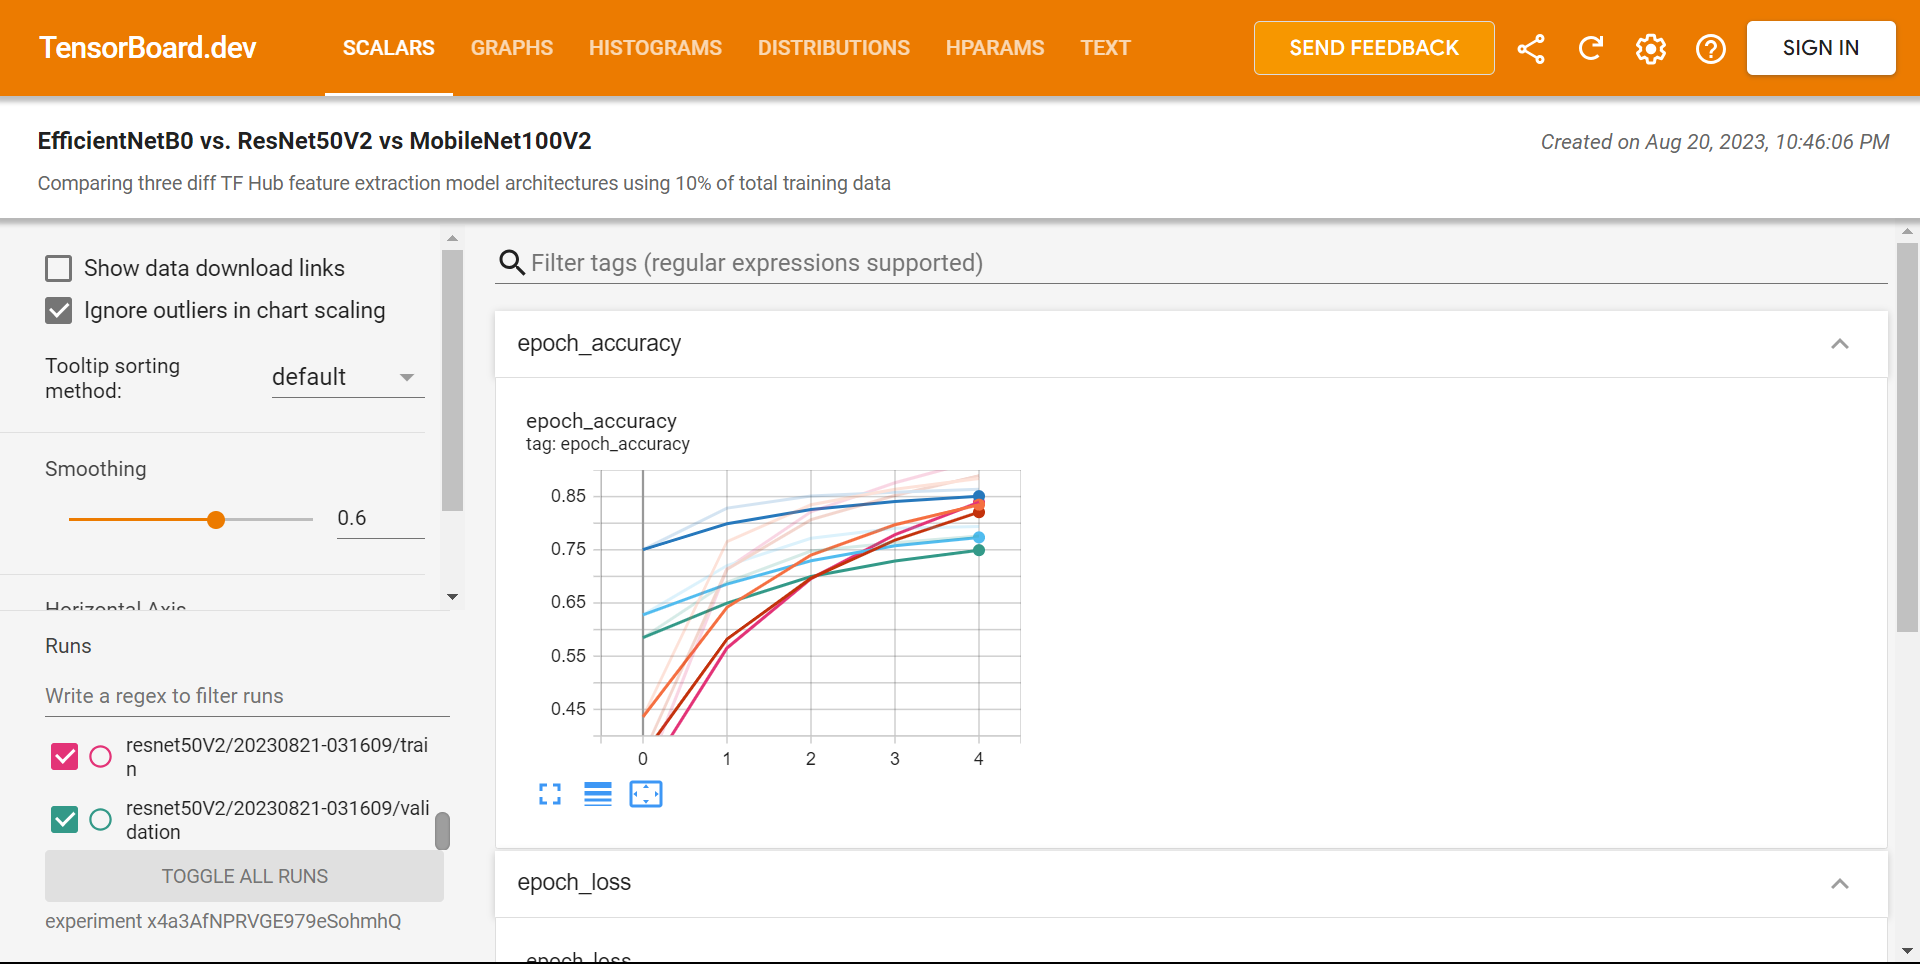